In [64]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc, 
    log_loss, precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.decomposition import PCA
import cv2
import os
from tqdm import tqdm  
import random
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [65]:
# Define base directory for your files
base_path = r"G:\my subjects\PROJECTS\Machine Learning project\german_traffic_signs classification Using Logistic Regression &KNN\german_traffic_signs"

In [66]:
# 1. Load Metadata
meta_path = os.path.join(base_path, "meta.csv")
train_path = os.path.join(base_path, "train.csv")
test_path = os.path.join(base_path, "test.csv")

meta_data = pd.read_csv(meta_path)
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print("Loaded Files:")
print(f"Meta.csv shape: {meta_data.shape}")
print(f"Train.csv shape: {train_data.shape}")
print(f"Test.csv shape: {test_data.shape}")


Loaded Files:
Meta.csv shape: (43, 5)
Train.csv shape: (39209, 8)
Test.csv shape: (12630, 8)


In [67]:
train_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [68]:
selected_classes = [0, 12, 13, 15, 33]
filtered_train_data = train_data[train_data['ClassId'].isin(selected_classes)]
filtered_test_data = test_data[test_data['ClassId'].isin(selected_classes)]
print(filtered_train_data.head())
print(filtered_test_data.head())

     Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
360     29      30       5       6      24      25        0   
361     30      30       5       5      25      25        0   
362     30      30       5       5      25      25        0   
363     31      31       5       5      26      26        0   
364     30      32       5       6      25      26        0   

                              Path  
360  Train/0/00000_00000_00000.png  
361  Train/0/00000_00000_00001.png  
362  Train/0/00000_00000_00002.png  
363  Train/0/00000_00000_00003.png  
364  Train/0/00000_00000_00004.png  
    Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
3      27      29       5       5      22      24       33  Test/00003.png
7      32      33       5       5      26      28       12  Test/00007.png
10     38      37       6       5      33      32       12  Test/00010.png
21     52      55       5       6      47      49       33  Test/00021.png
26     56      49       

In [69]:
filtered_train_data = filtered_train_data.sample(frac=1).reset_index(drop=True)
print(filtered_train_data.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     33      33       5       5      28      28       12   
1     50      45       6       5      45      40       13   
2     44      49       5       5      39      44       12   
3     30      29       6       5      25      24        0   
4     26      25       6       5      21      20       15   

                             Path  
0  Train/12/00012_00017_00004.png  
1  Train/13/00013_00010_00012.png  
2  Train/12/00012_00066_00014.png  
3   Train/0/00000_00002_00004.png  
4  Train/15/00015_00020_00000.png  


In [70]:
# Step 4: Load images and labels for ONLY the selected classes

# Define the selected classes
selected_classes = [0, 12, 13, 15, 33]

X_train, y_train, X_test, y_test = [], [], [], []
root_path = r"G:\my subjects\PROJECTS\Machine Learning project\german_traffic_signs classification Using Logistic Regression &KNN\german_traffic_signs"
image_size = (50, 50)

for index, row in filtered_train_data.iterrows():
    img_path = os.path.join(root_path, row['Path'])  
    if not os.path.exists(img_path): 
        print(f"Image not found: {img_path}")
        continue

    img = cv2.imread(img_path)
    if img is not None:
        img_resized = cv2.resize(img, image_size)

        
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        img_equalized = cv2.equalizeHist(img_gray)

        center = (image_size[0] // 2, image_size[1] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, 15, 1)  
        img_rotated = cv2.warpAffine(img_equalized, rotation_matrix, image_size)

        img_flipped = cv2.flip(img_rotated, 1)

        img_normalized = img_flipped / 255.0

        X_train.append(img_normalized)
        y_train.append(row['ClassId'])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"Number of Training Images: {len(X_train)}")
print(f"Training Data Shape: {X_train.shape}")



Number of Training Images: 5789
Training Data Shape: (5789, 50, 50)


In [71]:
root_path = r"G:\my subjects\PROJECTS\Machine Learning project\german_traffic_signs classification Using Logistic Regression &KNN\german_traffic_signs"

image_size = (50, 50)

X_test = []
y_test = []

for index, row in filtered_test_data.iterrows():
    img_path = os.path.join(root_path, row['Path'])  
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    img = cv2.imread(img_path)
    if img is not None:
       
            img_resized = cv2.resize(img, image_size)
            
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            
            img_equalized = cv2.equalizeHist(img_gray)
            
            center = (image_size[0] // 2, image_size[1] // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, 15, 1)
            img_rotated = cv2.warpAffine(img_equalized, rotation_matrix, image_size)
            
            img_flipped = cv2.flip(img_rotated, 1)
            
            img_normalized = img_flipped / 255.0
            
            X_test.append(img_normalized)
            y_test.append(row['ClassId'])  
       

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Number of Test Images: {len(X_test)}")
print(f"Test Data Shape: {X_test.shape}")

Number of Test Images: 1890
Test Data Shape: (1890, 50, 50)


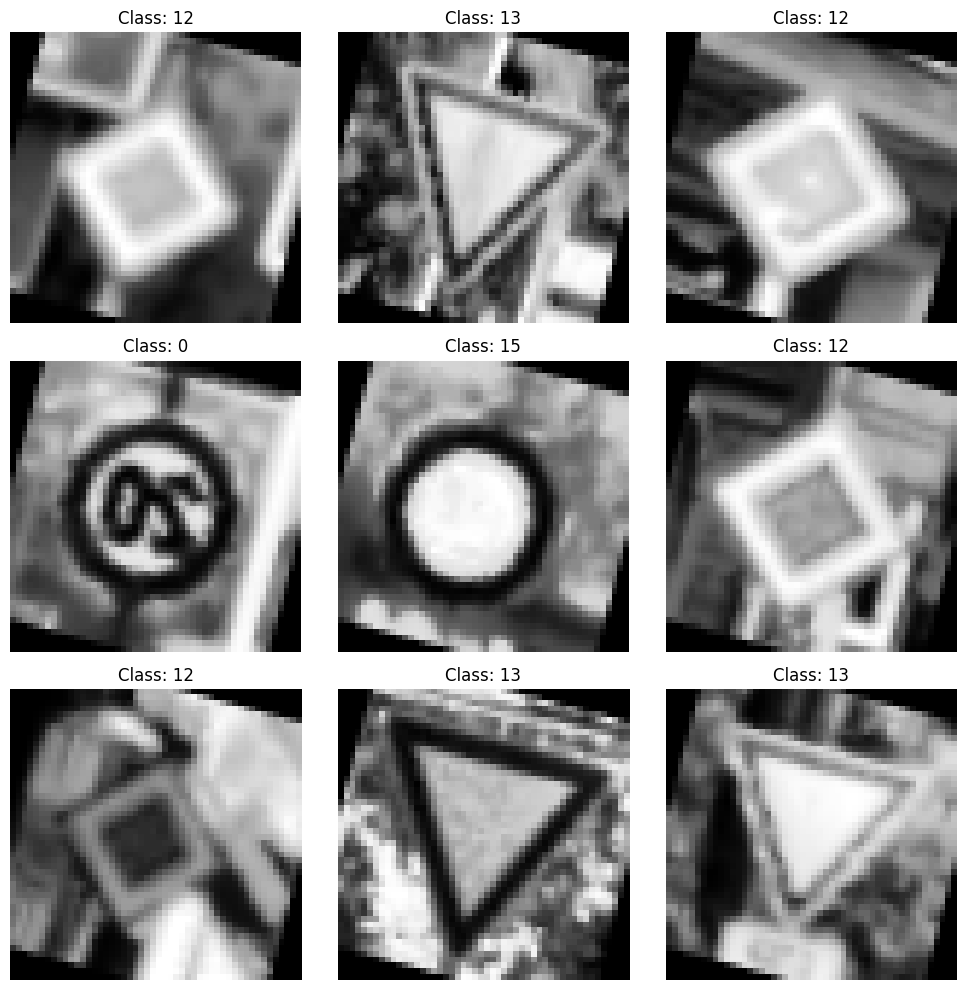

In [72]:
plt.figure(figsize=(10, 10))
for i in range(min(9, len(X_train))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i].reshape(image_size[0], image_size[1]), cmap='gray')
    plt.title(f"Class: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [73]:
# Flatten images 
X_train = X_train.reshape(X_train.shape[0], -1)  
X_test= X_test.reshape(X_test.shape[0], -1) 

In [74]:
# Standardize the data before applying PCA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
from sklearn.decomposition import PCA
# Perform PCA
#PCA reduces the dimensionality of the data from (50, 50) (2500 elements) to (50) (50 elements).
pca = PCA(n_components=50)  
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(f"X_train shape after PCA: {X_train.shape}")
print(f"X_test shape after PCA: {X_test.shape}")

X_train shape after PCA: (5789, 50)
X_test shape after PCA: (1890, 50)


In [76]:
# 6. Train Logistic Regression Model
model = OneVsRestClassifier(LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr'))
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(multi_class='ovr',
                                                 random_state=42,
                                                 solver='liblinear'))

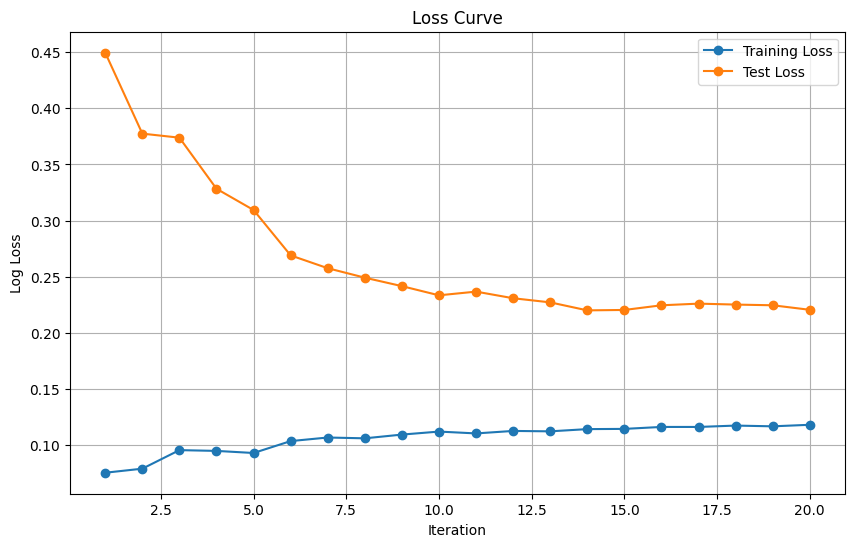

In [77]:
from sklearn.metrics import log_loss

# Initialize variables to store loss values
train_losses = []
test_losses = []

# Split the training data into small chunks (simulating epochs)
n_iterations = 20
subset_size = len(X_train) // n_iterations

for i in range(1, n_iterations + 1):
    # Use an increasing subset of training data
    subset_X_train = X_train[:i * subset_size]
    subset_y_train = y_train[:i * subset_size]

    # Train the model on the subset
    model.fit(subset_X_train, subset_y_train)

    # Predict probabilities for training and test sets
    train_prob = model.predict_proba(subset_X_train)
    test_prob = model.predict_proba(X_test)

    # Calculate log loss for training and test sets
    train_loss = log_loss(subset_y_train, train_prob)
    test_loss = log_loss(y_test, test_prob)

    # Store the losses
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, n_iterations + 1), test_losses, label="Test Loss", marker='o')
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.legend()
plt.grid()
plt.show()


In [78]:
# 7. Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

In [79]:
# Visualize Predictions After Inverse PCA
#PCA inverse_transform() method to restore the data into its pre-PCA form (approximate 2D images).
X_test_inverse = pca.inverse_transform(X_test)
X_test_reshaped = X_test_inverse.reshape(-1, image_size[0], image_size[1])


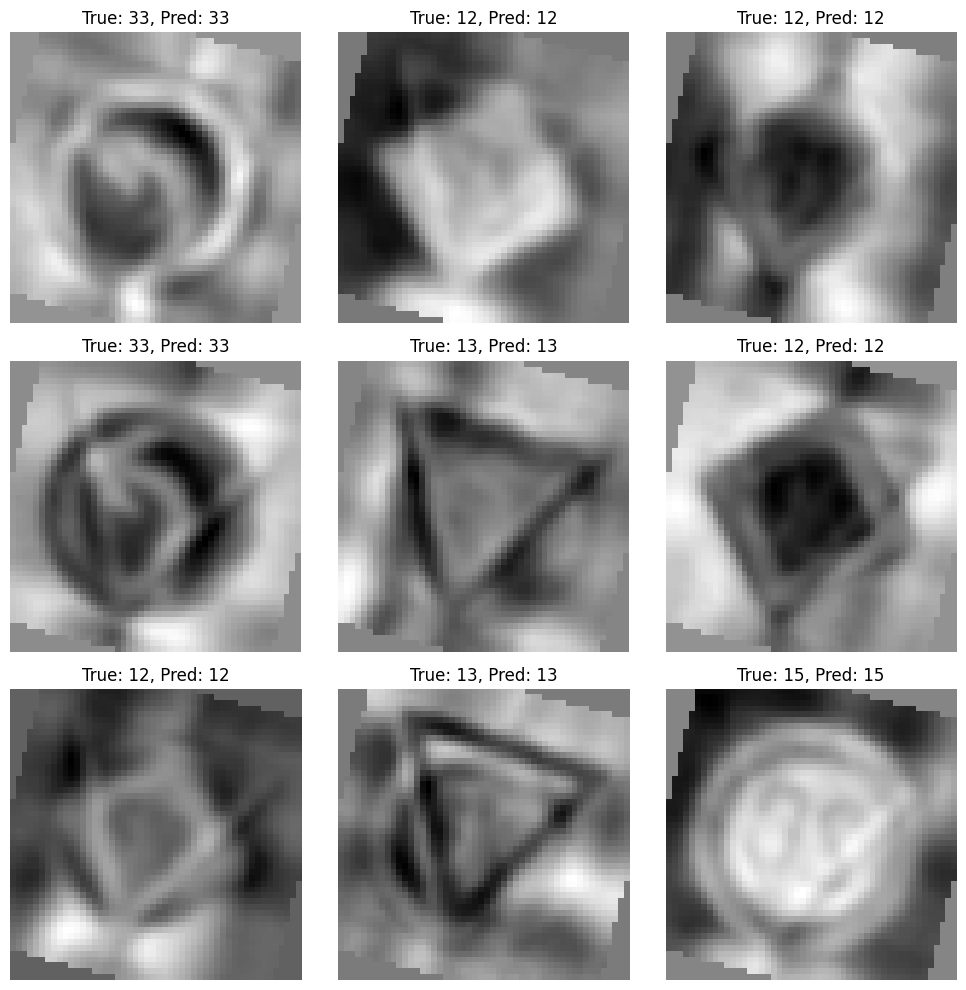

In [80]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_reshaped[i], cmap='gray')
    plt.title(f"True: {y_test[i]}, Pred: {y_pred[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [81]:
# Metrics: Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Precision, Recall, F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}, index=np.unique(y_train))
print(classification_report(y_test, y_pred))
print(f'Precision (macro): {precision.mean():.2f}')
print(f'Recall (macro): {recall.mean():.2f}')
print(f'F1 Score (macro): {f1.mean():.2f}')

print("\nMetrics Summary:")
print(metrics_df)
train_losses = []
# Log Loss
loss = log_loss(y_test, y_prob)
print("\nLog Loss:", loss)
train_losses.append(loss)
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

Test Accuracy: 0.9396825396825397
              precision    recall  f1-score   support

           0       0.93      0.68      0.79        60
          12       0.95      0.96      0.96       690
          13       0.94      0.97      0.96       720
          15       0.85      0.81      0.83       210
          33       0.99      0.95      0.97       210

    accuracy                           0.94      1890
   macro avg       0.93      0.88      0.90      1890
weighted avg       0.94      0.94      0.94      1890

Precision (macro): 0.93
Recall (macro): 0.88
F1 Score (macro): 0.90

Metrics Summary:
    Precision    Recall  F1 Score
0    0.931818  0.683333  0.788462
12   0.948645  0.963768  0.956147
13   0.940940  0.973611  0.956997
15   0.850000  0.809524  0.829268
33   0.995000  0.947619  0.970732

Log Loss: 0.2204152998225784


<Figure size 1000x600 with 0 Axes>

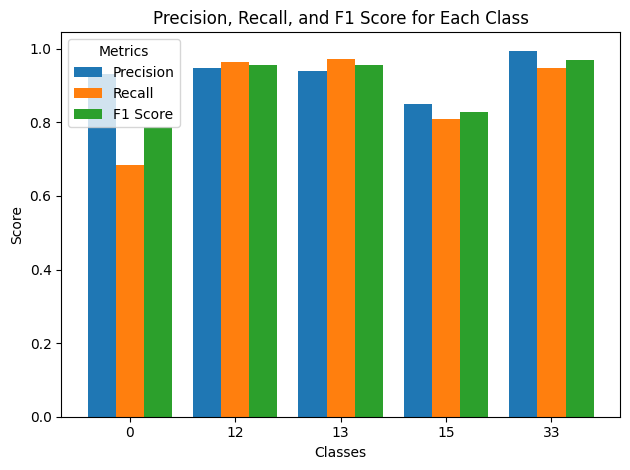

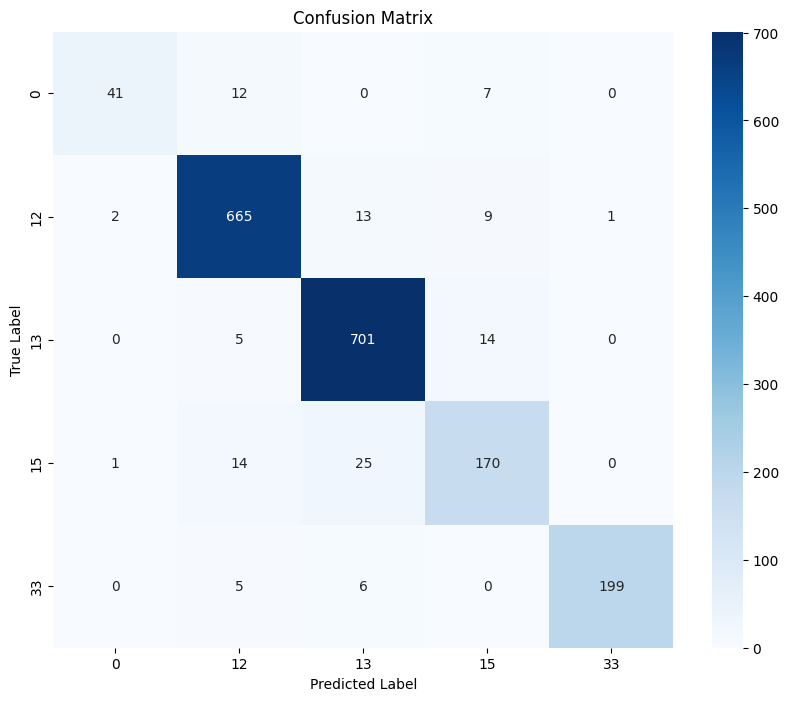

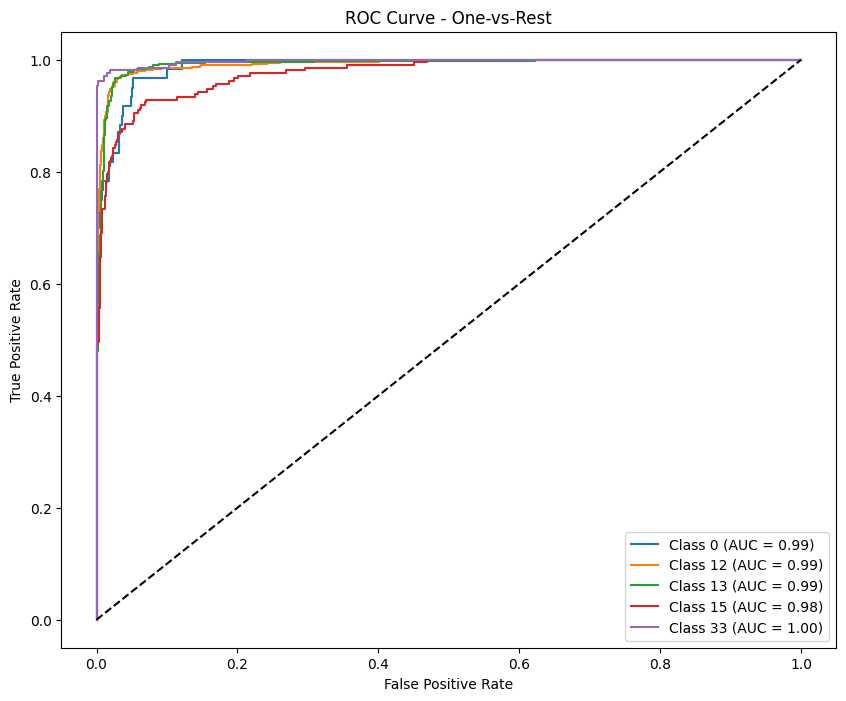

AUC for class 0: 0.99
AUC for class 1: 0.99
AUC for class 2: 0.99
AUC for class 3: 0.98
AUC for class 4: 1.00


In [82]:
# 8. Visualizations
# Bar Plot for Precision, Recall, F1 Score
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', width=0.8)
plt.title('Precision, Recall, and F1 Score for Each Class')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curves
label_binarizer = LabelBinarizer()
y_onehot_test = label_binarizer.fit_transform(y_test)

fpr, tpr, roc_auc = {}, {}, {}
for i, class_label in enumerate(label_binarizer.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC-AUC
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(label_binarizer.classes_):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_label} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One-vs-Rest')
plt.legend()
plt.show()
# Output the AUC score for each class
for i in range(y_onehot_test.shape[1]):
    print(f"AUC for class {i}: {roc_auc[i]:.2f}")